In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [2]:
######################################################################
# CartPole ( https://www.gymlibrary.dev/environments/classic_control/cart_pole/ )
#=====================================================================
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.reset()
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<CartPoleEnv<CartPole-v1>>>>>

In [3]:
# minimum and maximum of [cart_position, cart_velocity, pole_angle, pole_angular_velocity]
env.observation_space 

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

In [4]:
observation_dim = env.observation_space.shape
observation_dim

(4,)

In [5]:
if isinstance(env.observation_space, gym.spaces.Discrete): # dicrete observation space
    observation_dim = env.observation.n
elif isinstance(env.observation_space, gym.spaces.Box): # continuous observation space
    observation_dim = env.observation_space.shape[0]
observation_dim

4

In [6]:
env.action_space # 0 or 1

Discrete(2)

In [7]:
action_dim = env.action_space.n
action_dim

2

In [8]:
if isinstance(env.action_space, gym.spaces.Discrete): # dicrete action space
    action_dim = env.action_space.n
elif isinstance(env.action_space, gym.spaces.Box): # continuous action space
    action_dim = env.action_space.shape[0]
action_dim

2

In [9]:
env.action_space.sample() # random action

0

In [10]:
# take a random action
observation, reward, terminated, truncated, info = env.step(env.action_space.sample())
observation, reward, terminated, truncated, info

(array([ 0.04594922,  0.19823673,  0.0455728 , -0.23337096], dtype=float32),
 1.0,
 False,
 False,
 {})

In [11]:
env_screen = env.render() # numpy.ndarray
env_screen.shape

(400, 600, 3)

In [12]:
env_screen

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [13]:
import gym
import numpy as np

# iteration
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.reset()

total_reward = 0.0
terminated = False
env_screens = []
while not terminated:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    env_screen = env.render() # numpy.ndarray
    env_screens.append(env_screen)
    total_reward += reward

env.close()
total_reward

15.0

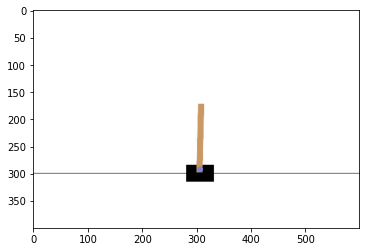

In [14]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

####################################################
# create an animation
#===================================================

fig, ax = plt.subplots()
im = ax.imshow(env_screens[0])

def update(i):
    im.set_data(env_screens[i])
    return (im)

animation = FuncAnimation(fig=fig, func=update, frames=len(env_screens), interval=100)
#plt.show()

# display the animation in the notebook
HTML(animation.to_jshtml())

In [15]:
#################################################################
# compute the expected reward if we always take random actions
#################################################################

import gym
import numpy as np

env = gym.make("CartPole-v1", render_mode="rgb_array")
NUM_EPISODES = 1000
rewards = np.zeros(NUM_EPISODES)

for episode in range(NUM_EPISODES):
    env.reset()
    observation, reward, terminated, truncated, info = env.step(env.action_space.sample())
    total_reward = reward
    while not terminated:
        # take a random action
        action = env.action_space.sample()
        next_observation, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
    rewards[episode] = total_reward
env.close()

rewards.mean() # expected reward is about 22

21.947

In [16]:
# observation
env.reset()
observation, reward, terminated, truncated, info = env.step(env.action_space.sample())
cart_position, cart_velocity, pole_angle, pole_angular_velocity = observation

# 4 values of a state
cart_position, cart_velocity, pole_angle, pole_angular_velocity

(0.015531689, -0.24149907, -0.04476607, 0.2915021)

## Solve cartpole-v1 using stable baseline 3

In [3]:
import gymnasium as gym
from stable_baselines3 import PPO

# Create the environment
env = gym.make("CartPole-v1")

# Initialize the PPO model (MlpPolicy = Multilayer Perceptron policy)
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=1000) # Train the model for 100,000 timesteps
model.save("ppo_cartpole") # Save the trained model
env.close()


C:\Users\t1\anaconda3\Lib\site-packages\torch\cuda\__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ..\c10\cuda\CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22       |
|    ep_rew_mean     | 22       |
| time/              |          |
|    fps             | 1463     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------


In [ ]:
import gymnasium as gym
from stable_baselines3 import PPO

# Load the trained model
model = PPO.load("ppo_cartpole")
env = gym.make("CartPole-v1", render_mode="human")

# Run one episode
obs, _ = env.reset()
done, truncated = False, False
MAX_STEP = 500
total_reward = 0.0
for i in range(MAX_STEP):
    action, _ = model.predict(obs, deterministic=True)  # Get action
    obs, reward, done, truncated, _ = env.step(action)
    total_reward += reward
    env.render()  # Show environment
    time.sleep(0.02)  # Add delay for better visualization
    if done or truncated:
        break
env.close()
total_reward